In [1]:
import sys
sys.path.append('../code')
from init_mooc_nb import *
init_notebook()

from wraparound import wraparound
from scipy import linalg as la
from functools import reduce

pi_ticks = [(-np.pi, r"$-\pi$"),
            (-np.pi / 2, r"$-\pi/2$"),
            (0, r"$0$"),
            (np.pi / 2, r"$\pi/2$"),
            (np.pi, r"$\pi$")]


def checkerboard(W=None):
    lat = kwant.lattice.general([[2, 0], [1, 1]], [(0, 0), (1, 0)])
    a, b = lat.sublattices
    if W:
        def lead_shape(pos):
            (x, y) = pos
            return (0 <= y < W and 0 <= x < W)
        sys = kwant.Builder(kwant.TranslationalSymmetry((1, 1)))
        sys[a.shape(lead_shape, (0, 0))] = 0
        sys[b.shape(lead_shape, (1, 0))] = 0
    else:
        sys = kwant.Builder(kwant.TranslationalSymmetry(*lat.prim_vecs))    
        sys[lat.shape(lambda pos: True, (0, 0))] = 0
    sys[kwant.HoppingKind((0, 0), b, a)] = lambda s1, s2, p: -p.t1
    sys[kwant.HoppingKind((-1, 1), b, a)] = lambda s1, s2, p: -p.t2
    sys[kwant.HoppingKind((1, 0), a, b)] = lambda s1, s2, p: -p.t3
    sys[kwant.HoppingKind((0, 1), a, b)] = lambda s1, s2, p: -p.t4
    return sys


def evolution_operator(hamiltonians, T):
    n = len(hamiltonians)
    exps = [la.expm(-1j * h * T / n) for h in hamiltonians]
    return reduce(np.dot, exps)


def get_h_k(lead, p):
    bands = kwant.physics.Bands(lead, args=[p])
    h, t = bands.ham, bands.hop
    return lambda k: h + t * np.exp(-1j * k) + t.T.conj() * np.exp(1j * k)

Populated the namespace with:
np, matplotlib, kwant, holoviews, init_notebook, interact, display_html, plt, pf, SimpleNamespace, pprint_matrix, scientific_number, pretty_fmt_complex
from code/edx_components:
MoocVideo, PreprintReference, MoocDiscussion, MoocCheckboxesAssessment, MoocMultipleChoiceAssessment, MoocPeerAssessment, MoocSelfAssessment
from code/functions:
spectrum, hamiltonian_array, h_k, pauli


Press this button to show/hide the code used in the notebook:

**No content above this line is visible in edX**

# Introduction

Today's topic, Floquet topological insulators, is introduced by Mark Rudner from the Niels Bohr Institute at Copenhagen.

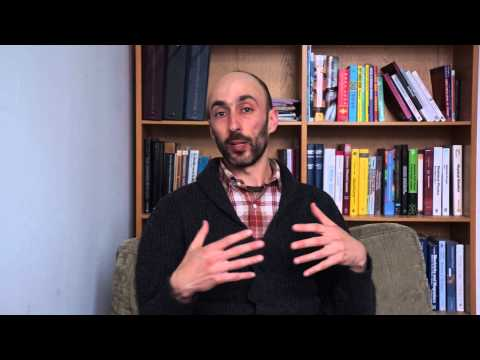

In [2]:
MoocVideo("1peVp_IZ7Ts", src_location="11.1-intro")

# Periodically driven systems

We will now learn about a new generalization of topology, namely how it applies to the quantum evolution of systems with a time-dependent Hamiltonian. As you may recall, we've already encountered time dependence, back when we considered quantum pumps. However, back then we assumed that the time evolution was very slow, such that the system stayed in the ground state at all times, i.e. it was adiabatic. Can we relax the adiabaticity constraint? Can we find an analog of topology in systems that are driven so fast that energy isn't conserved?

For the same reasons as before, we'll consider periodic driving

$$
H(t + T) = H(t).
$$

Once again, this is necessary because otherwise, any system can be continuously deformed into any other, and there is no way to define a gap.

Before we get to topology, let's refresh our knowledge of time-dependent systems.

The Schrödinger equation is:

$$
i\frac{d \psi}{dt} = H(t) \psi.
$$

It is a linear equation, so we can write its solution as

$$
\psi(t_2) = U(t_2, t_1) \psi(t_1),
$$

where $U$ is a unitary *time evolution operator*. It solves the same Schrödinger equation as the wave function, and is equal to the identity matrix at the initial time. It is commonly written as

$$
U(t_2, t_1) = \mathcal{T} \exp\,\left[-i\int_{t_1}^{t_2} H(t) dt\right],
$$

where $\mathcal{T}$ represents time-ordering (not time-reversal symmetry). The time-ordering is just a short-hand notation for the need to solve the full differential equation, and it is necessary if the Hamiltonians evaluated at different times in the integral do not commute.

The time evolution operator satisfies a very simple multiplication rule:

$$
U(t_3, t_1) = U(t_3, t_2) U(t_2, t_1),
$$

which just says that time evolution from $t_1$ to $t_3$ is a product of time evolutions from $t_1$ to $t_2$ and then from $t_2$ to $t_3$. Of course an immediate consequence of this is the equality $U(t_2, t_1)^\dagger = U(t_2, t_1)^{-1} = U(t_1, t_2)$.

## Floquet theory

The central object for the study of driven systems is the evolution operator over one period of the driving,

$$
U(t + T, t) \equiv U,
$$

which is called the Floquet time evolution operator. It is important because it allows us to identify the wave functions that are the same if an integer number of drive periods passes. These are the stationary states of a driven system, and they are given by the eigenvalues of the Floquet operator:

$$
U \psi = e^{i \alpha} \psi.
$$

The stationary states are very similar to the eigenstates of a stationary Hamiltonian, except that they are only stationary if we look at fixed times $t + nT$. That's why the Floquet time evolution operator is also called a stroboscopic time evolution operator.

We can very easily construct a Hermitian matrix from $U$, the **Floquet Hamiltonian**:

$$
H_\textrm{eff} = i T^{-1} \,\ln U.
$$

Its eigenvalues $\varepsilon = \alpha / T$ are called quasi-energies, and they always belong to the interval $-\pi < \alpha \leq \pi$.

If the system is translationally invariant, we can study the effective band structure of $H_\textrm{eff}(\mathbf{k})$, find an energy in which the bulk Hamiltonian has no states, and study the topological properties of such a Hamiltonian: most of the things we already know still apply.

Of course, selecting a single quasi-energy as the Fermi level is arbitrary, since the equilibrium state of driven systems doesn't correspond to a Fermi distribution of filling factors, but at least it seems close enough for us to try to apply topological ideas.

In [3]:
question = ("But wait, we arbitrarily chose the starting point $t$ in time for calculating the "
            "Floquet operator. What if we chose a different one?")

answers = ["The starting time is just an extra parameter of our system, and topology depends on it.",
           "It doesn't matter, the wave function evolution within one period "
           "can be neglected, since we are interested in many periods.",
           "There's only one correct starting point in time.",
           "It doesn't matter since the quasienergies are independent of the starting point."]

explanation = ("Choosing a different starting point applies a unitary transformation "
               "to the Floquet evolution operator, and so it keeps the quasienergies the same.")

MoocMultipleChoiceAssessment(question=question, answers=answers, correct_answer=3, explanation=explanation)

MoocMultipleChoiceAssessment(**{'explanation': 'Choosing a different starting point applies a unitary transformation to the Floquet evolution operator, and so it keeps the quasienergies the same.', 'correct_answer': 3, 'question': 'But wait, we arbitrarily chose the starting point $t$ in time for calculating the Floquet operator. What if we chose a different one?', 'display_name': 'Question', 'answers': ['The starting time is just an extra parameter of our system, and topology depends on it.', "It doesn't matter, the wave function evolution within one period can be neglected, since we are interested in many periods.", "There's only one correct starting point in time.", "It doesn't matter since the quasienergies are independent of the starting point."], 'max_attempts': 2})

# Driven Majorana wire

Let us start by considering something we know very well, namely the superconducting Majorana nanowire model from week 2. This model has three important parameters which determine whether the wire is in the topological Majorana phase or not: the chemical potential $\mu$, the superconducting gap $\Delta$, and the magnetic field $B$. The topological phase with unpaired Majorana modes at zero energy is realized for $B > \sqrt{\mu^2 + \Delta^2}$.

Now, imagine that we can periodically drive some of these parameters. For instance, consider the simple example when

$$
\mu = \left\{
\begin{matrix}
\mu_1 \quad \text{for } 0 < t < T/2 \\
\mu_2 \quad \text{for } T/2 < t < T
\end{matrix}\right.
$$

Then, the integral to find the time evolution operator is easy to evaluate, and we simply have

$$
U = \exp(i T H_2 / 2) \exp(i T H_1 / 2)
$$

with $H_1$ and $H_2$ the nanowire Hamiltonians with chemical potential $\mu_1$ and $\mu_2$. A peculiar property of driven systems is that as the period becomes large, the band structure 'folds': if the driving is very weak, and the original Hamiltonian has energy $E$, the Floquet Hamiltonian has a much smaller quasienergy $(E\bmod 2\pi /T)$. This means that even when $H_1$ and $H_2$ correspond to trivial systems, we can still obtain nontrivial topology if we make the period large enough, as you can see for yourself:

b':HoloMap   [n]\n   :Layout\n      .Overlay.Finite_system :Overlay\n         .Path.Finite_system :Path   [Driving period $(JT)$,Quasi-energy $(ET)$]\n         .VLine.I            :VLine   [x,y]\n      .Path.Floquet_bands    :Path   [$k$,$E_kT$]'
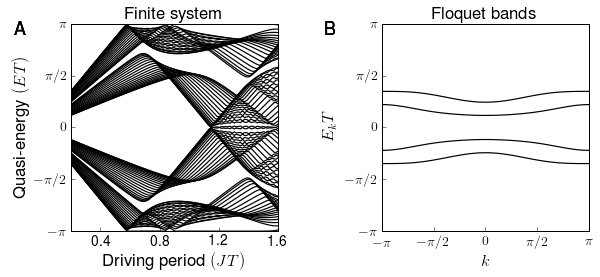
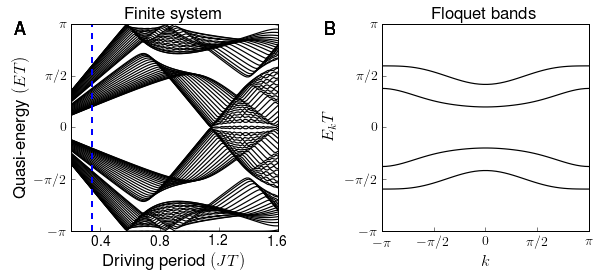
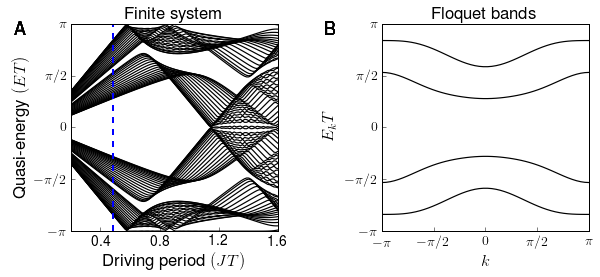
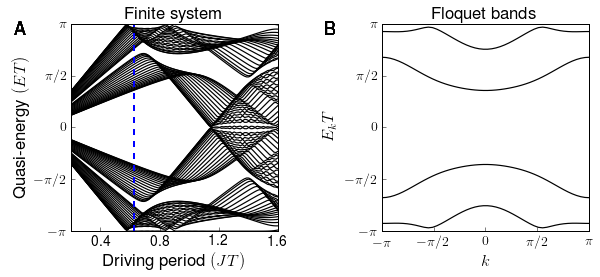
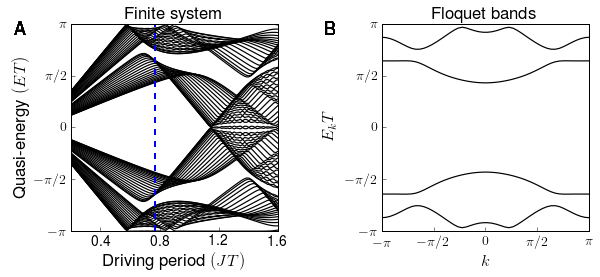
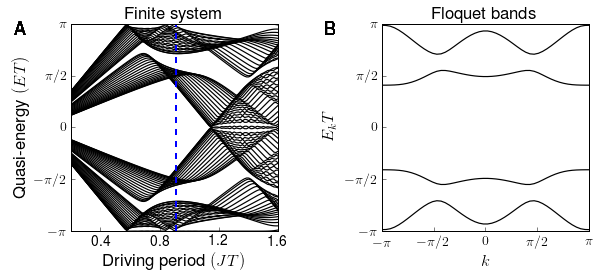
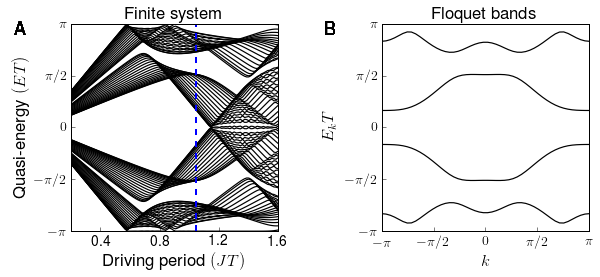
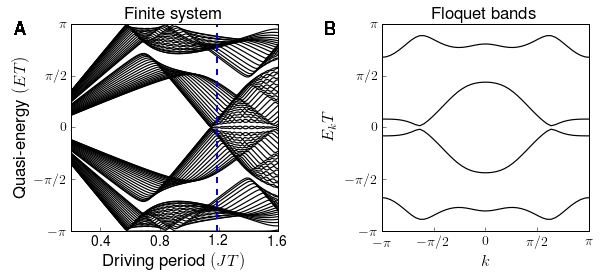
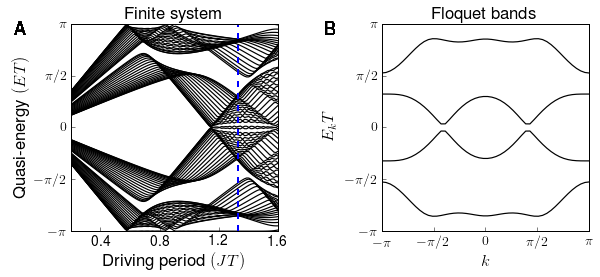
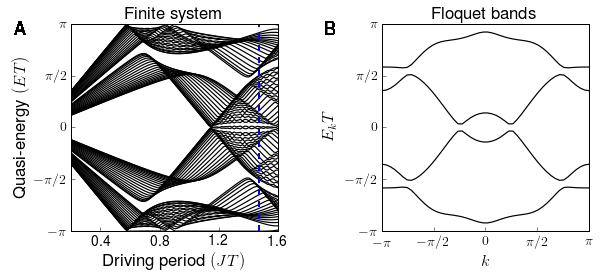

In [4]:
%%opts Path {+axiswise}

def nanowire_chain(L=None):
    lat = kwant.lattice.chain()

    def onsite(site, p):
        return (2*p.t - p.mu) * pauli.szs0 + p.B * pauli.s0sz + p.delta * pauli.sxs0

    def hopping(site1, site2, p):
        return -p.t * pauli.szs0 + 0.5 * 1j * p.alpha * pauli.szsx

    if L:
        sys = kwant.Builder()
    else:
        sys = kwant.Builder(kwant.TranslationalSymmetry((-1,)))
        L = 1

    sys[(lat(x) for x in range(L))] = onsite
    sys[kwant.HoppingKind((1,), lat)] = hopping

    return sys


def calculate_finite_spectrum(periods, hamiltonians):
    energies = []
    for T in periods:
        U = evolution_operator(hamiltonians, T)
        phases = np.angle(la.eigvals(U))
        phases = np.sort(np.abs(phases))
        ev = np.sort([(-1)**n * val for n, val in enumerate(phases)])
        energies.append(ev)
    return np.array(energies).real


def calculate_bands(momenta, hamiltonians_k, T):
    energies = []
    for k in momenta:
        hamiltonians = [h_k(k) for h_k in hamiltonians_k]
        U = evolution_operator(hamiltonians, T)
        phases = np.angle(la.eigvals(U))
        phases = np.sort(np.abs(phases))
        ev = np.sort([(-1)**n * val for n, val in enumerate(phases)])
        energies.append(ev)
    return np.array(energies).real


J = 2.0
p1 = SimpleNamespace(t=J/2, mu=-1*J, B=J, delta=2*J, alpha=J)
p2 = SimpleNamespace(t=J/2, mu=-3*J, B=J, delta=2*J, alpha=J)

sys = nanowire_chain(L=20).finalized()
H1 = sys.hamiltonian_submatrix(args=[p1])
H2 = sys.hamiltonian_submatrix(args=[p2])

lead = wraparound(nanowire_chain(L=None)).finalized()
h1_k = lambda kx: lead.hamiltonian_submatrix(args=[p1, kx])
h2_k = lambda kx: lead.hamiltonian_submatrix(args=[p2, kx])

periods = np.linspace(0.2 / J, 1.6 / J, 100)
momenta = np.linspace(-np.pi, np.pi)

energies = calculate_finite_spectrum(periods, [H1, H2])
spectrum = np.array([calculate_bands(momenta, [h1_k, h2_k], T) for T in periods])


def plot(n):
    T = J * periods[n]

    plot_1 = holoviews.Path((J * periods, energies),
                         kdims=[r'Driving period $(JT)$', r'Quasi-energy $(ET)$'],
                         label='Finite system')(plot={'xticks': 5, 'yticks': pi_ticks})

    VLine = holoviews.VLine(T)(style={'color': 'b', 'linestyle': '--'})

    plot_2 = holoviews.Path((momenta, spectrum[n]),
                         kdims=['$k$', '$E_kT$'],
                         label='Floquet bands')(plot={'xticks': pi_ticks,
                                                      'yticks': pi_ticks,
                                                      'aspect': 'equal'})
    return plot_1 * VLine + plot_2

holoviews.HoloMap({n: plot(n) for n in np.arange(0, 100, 10)}, kdims=['n'])

On the left you see the Floquet spectrum of a finite system as a function of the driving period measured in units of the hopping strength, and on the right you see the Floquet dispersion in momentum space.

We now witness a cool phenomenon: just like in the undriven case, the particle-hole symmetry maps $E \rightarrow -E$, but now this means that not only $E = 0$ is special, but also $E = \pi$!

In other words, this means that there are two relevant gaps in the effective Floquet BdG Hamiltonian $H_\textrm{eff}$. Now, by using the same argument as we used for the regular Majoranas, we learn that if we have an isolated Floquet state with a quasienergy $\epsilon=0$ or $\epsilon=\pi$, it cannot be removed unless the gap surrounding it closes.

In other words:

> A Floquet superconductor has two types of Majorana bound states: the usual ones with quasienergy $\epsilon=0$, and the $\pi$-Majoranas that are as far from zero energy as possible.

So the calculation above reveals two interesting features of driven systems: the first is that the periodic driving can turn a trivial system into a non-trivial system with topologically protected Floquet states. The second is that topology is richer than in the non-driven system: for instance, here the richness comes from the fact that the topologically protected states may occur at two different points in the spectrum.

Now try to answer the following question: what's the topological invariant of this system? How do we tell whether normal Majoranas are present, and whether $\pi$-Majoranas are present? (We'll return to this question in the end of the lecture.)

# A Floquet Chern insulator

As a second example of a driven system that shows something that the undriven system doesn't, let's consider the following toy model.

We take a square lattice with time-dependent nearest neighbor hopping $t$. Next, let's engineer a time-evolution of the hopping between sites such that during a period $T$ hoppings are turned on in an alternate fashion, as in the following figure:

![](figures/time_steps.svg)

Each step lasts one quarter of a period.

Now let's tune the period such that the probability for an electron to hop along a hopping is one at the end of each quarter period [$t = (\pi / 2) / (T / 4)$]. Over the complete period the trajectories of electrons will look like this:

![](figures/floquet_bulk.svg)

Every electron makes a closed loop and ends up back at its origin. After every single period the system is back to its initial state. In other words, the Floquet operator is $U=1$, and $H_\textrm{eff}=0$.

Let's have a look at the dispersion, and also see what happens as we tune the driving period:

b':HoloMap   [$T$]\n   :Overlay\n      .Surface.I  :Surface   [$k_x$,$k_y$]   ($E$)\n      .Surface.II :Surface   [$k_x$,$k_y$]   ($E$)'
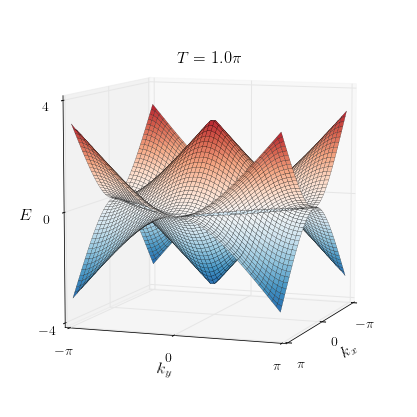
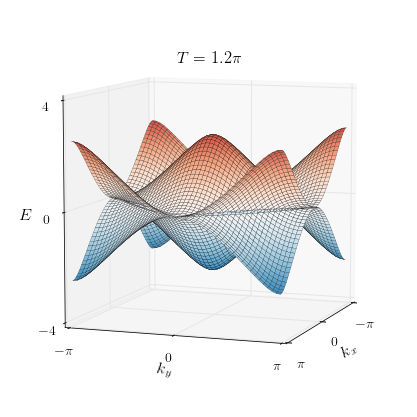
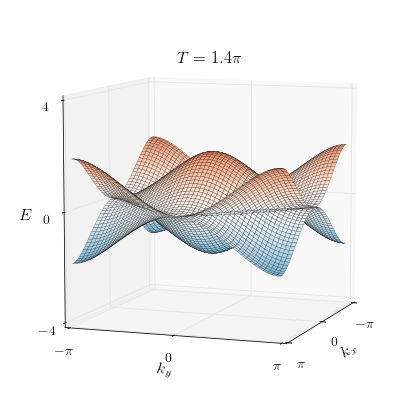
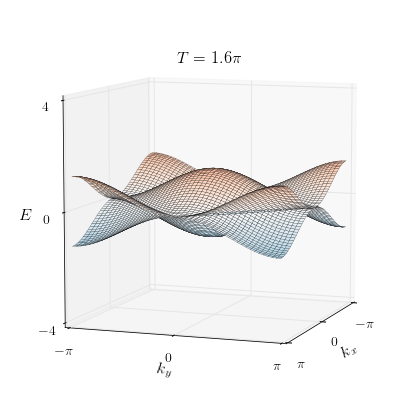
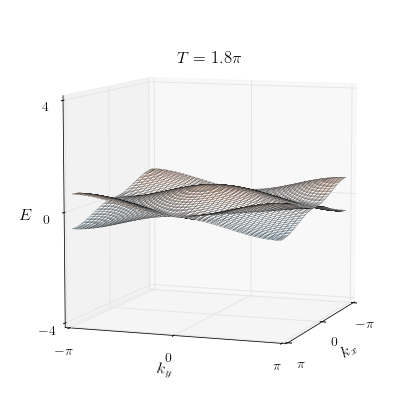
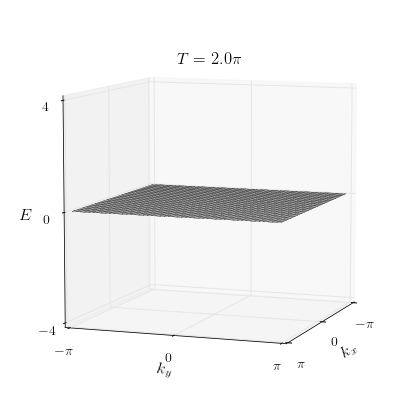
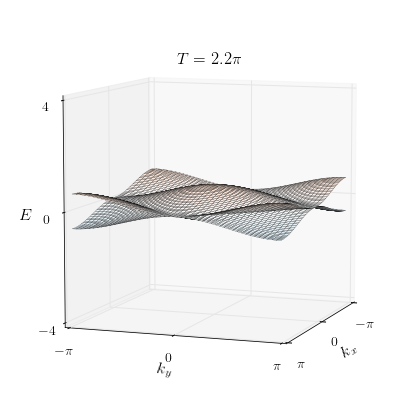
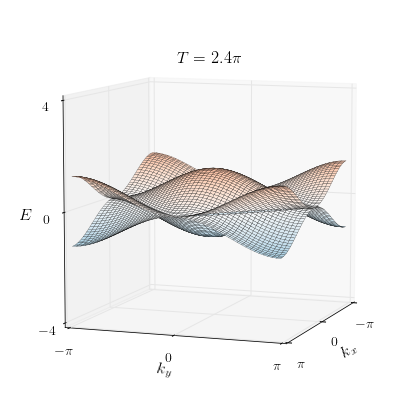
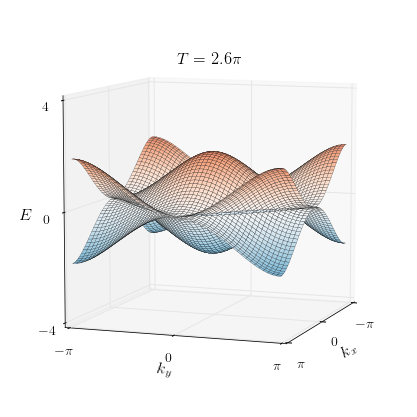
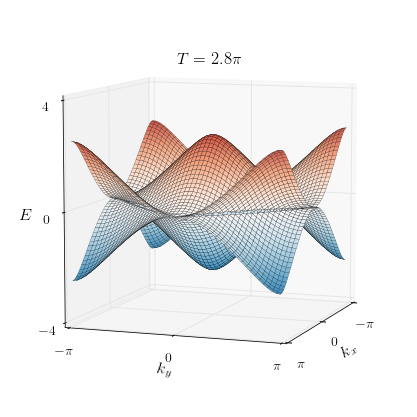
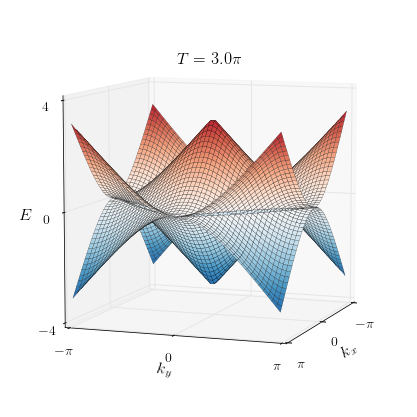

In [5]:
%%output size=200
def plot_dispersion_2D(T):
    sys = checkerboard()
    B = np.array(sys.symmetry.periods).T
    A = B.dot(np.linalg.inv(B.T.dot(B)))
    sys = wraparound(sys).finalized()
    
    def hamiltonian_k(par):
        def f(kx, ky):
            kx, ky = np.linalg.lstsq(A, [kx, ky])[0]
            ham = sys.hamiltonian_submatrix(args=[par, kx, ky])
            return ham
        return f

    hamiltonians_k = [
        hamiltonian_k(SimpleNamespace(t1=1, t2=0, t3=0, t4=0)),    
        hamiltonian_k(SimpleNamespace(t1=0, t2=1, t3=0, t4=0)),    
        hamiltonian_k(SimpleNamespace(t1=0, t2=0, t3=1, t4=0)),    
        hamiltonian_k(SimpleNamespace(t1=0, t2=0, t3=0, t4=1))]

    def get_energies(kx, ky):
        hamiltonians = [h_k(kx, ky) for h_k in hamiltonians_k]
        U = evolution_operator(hamiltonians, T)
        ev = np.sort(np.angle(la.eigvals(U)))
        return ev

    K = np.linspace(-np.pi, np.pi, 50)
    energies = np.array([[get_energies(kx, ky) for kx in K] for ky in K])

    ticks = {'xticks': pi_ticks[::2], 'yticks': pi_ticks[::2], 'zticks': 3}
    kwargs = {'extents': (-np.pi, -np.pi, -4, np.pi, np.pi, 4),
              'kdims': ['$k_x$', '$k_y$'],
              'vdims': ['$E$']}

    title = r'$T = {:.2} \pi$'.format(T / np.pi)
    
    return (holoviews.Surface(energies[:, :, 0], **kwargs)(plot=ticks) *
            holoviews.Surface(energies[:, :, 1], **kwargs)(plot=ticks)).relabel(title)

Ts = np.linspace(1, 3, 11, endpoint=True)
holoviews.HoloMap({T: plot_dispersion_2D(np.pi*T) for T in Ts}, kdims=['$T$'])

Now, there isn't a Hamiltonian which is more topologically trivial than the zero Hamiltonian. We may be tempted to conclude that our system is trivial and, by bulk-boundary correspondence, has no edge states.

That's something we can also very easily verify by computing the dispersion of a finite size ribbon:

b':HoloMap   [n]\n   :Path   [$k$,$E_kT$]'
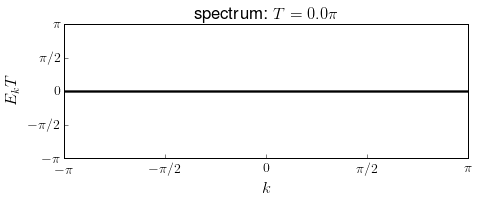
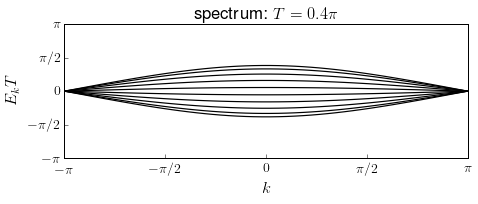
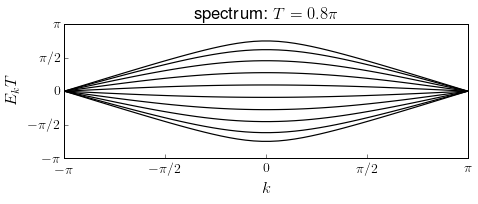
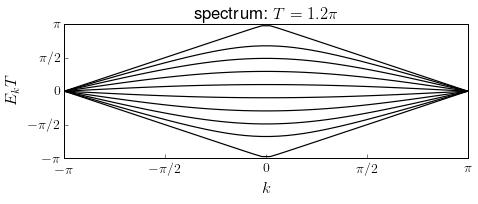
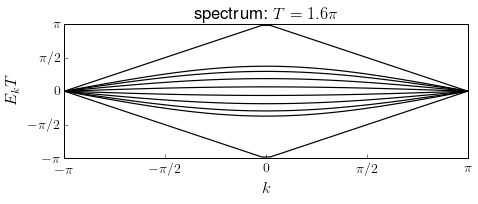
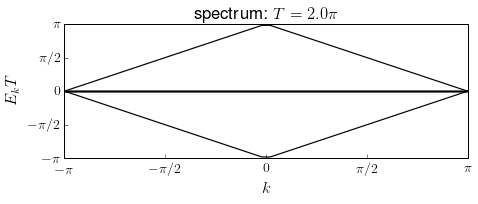
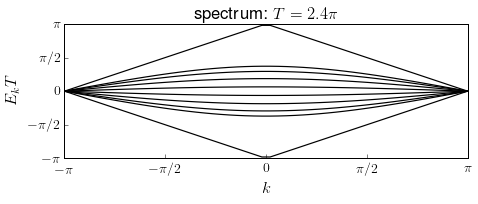
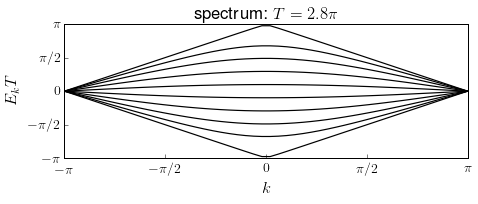
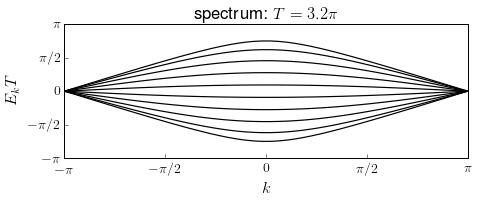
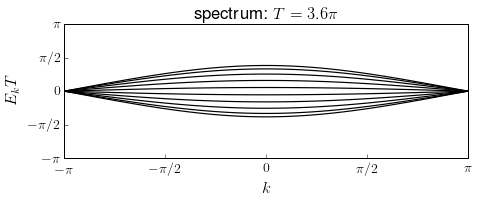
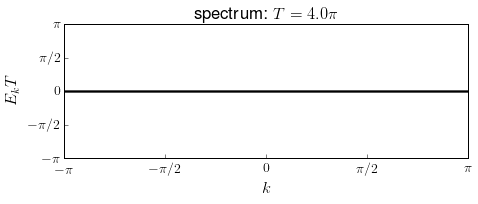

In [6]:
%%output size=200
def calculate_bands(momenta, hamiltonians_k, T):
    energies = []
    for k in momenta:
        hamiltonians = [h_k(k) for h_k in hamiltonians_k]
        U = evolution_operator(hamiltonians, T)
        energies.append(np.sort(np.angle(la.eigvals(U))))
    return np.array(energies).real


ribbon_lead = checkerboard(10).finalized()

hamiltonians_k = [
    get_h_k(ribbon_lead, SimpleNamespace(t1=1, t2=0, t3=0, t4=0)),
    get_h_k(ribbon_lead, SimpleNamespace(t1=0, t2=1, t3=0, t4=0)),
    get_h_k(ribbon_lead, SimpleNamespace(t1=0, t2=0, t3=1, t4=0)),
    get_h_k(ribbon_lead, SimpleNamespace(t1=0, t2=0, t3=0, t4=1))]

periods = np.linspace(0, 4*np.pi, 11)
momenta = np.linspace(-np.pi, np.pi)
spectrum = np.array([calculate_bands(momenta, hamiltonians_k, T) for T in periods])

def plot(n):
    T = periods[n]
    title = r'spectrum: $T={:.2} \pi$'.format(T/np.pi)
    return holoviews.Path((momenta, spectrum[n]),
                           label=title,
                           kdims=['$k$', '$E_kT$'])(plot={'xticks': pi_ticks,
                                                          'yticks': pi_ticks,
                                                          'aspect': 3})

holoviews.HoloMap({n: plot(n) for n in range(11)}, kdims=['n'])

We see something very different from our expectations. All the bulk states are indeed at $E=0$, but there are two branches of dispersion that are clearly propagating. These can only belong to the edges, and since the two edges look identical, these two modes have to belong to the opposite edges. We seem to conclude that even though the bulk Hamiltonian is trivial, the edges carry chiral edge states, as if there was a finite Chern number.

When the driving period is tuned to ensure the absence of bulk dispersion, we can also understand why the edge states appear. If we select a state that starts on the edge, and follow it for one period, we find that there are modes that never leave the edge, since one of the hoppings in the vertical direction is absent.

![](figures/trajectories.svg)

So what is happening with bulk-edge correspondence?

In [7]:
question = ("How can you change the chirality of the edge states in the figure above?")

answers = ["By changing the driving period.",
           "By reversing the driving protocol sequence.",
           "By changing the sign of the nearest neighbor hopping.",
           "By making the electrons start from the black sublattice."]

explanation = ("Reversing the driving protocol is the same as applying time-reversal symmetry, "
               "so it will reverse the direction of the chiral edge modes")

MoocMultipleChoiceAssessment(question=question, answers=answers, correct_answer=1, explanation=explanation)

MoocMultipleChoiceAssessment(**{'explanation': 'Reversing the driving protocol is the same as applying time-reversal symmetry, so it will reverse the direction of the chiral edge modes', 'correct_answer': 1, 'question': 'How can you change the chirality of the edge states in the figure above?', 'display_name': 'Question', 'answers': ['By changing the driving period.', 'By reversing the driving protocol sequence.', 'By changing the sign of the nearest neighbor hopping.', 'By making the electrons start from the black sublattice.'], 'max_attempts': 2})

# Bulk-edge correspondence in driven systems

The two examples we've studied reveal an imporant feature of topological Floquet insulators. It seems that knowing the bulk Floquet Hamiltonian is sufficient to calculate the topological invariant, by just applying the known expression to the Floquet Hamiltonian. However, that's not enough.

In rough terms, the reason for this insufficiency is due to Floquet topological insulators missing a topologically trivial state which can be taken as a reference. With any regular 2D Hamiltonian, we know that if we take $E \rightarrow -\infty$, we will get a trivial system with the Chern number zero. In a Floquet system, the only thing that lowering the energy tells us is that the Chern number is periodic in quasienergy, like any other observable property.

What do we need to know to derive the full topological invariant from the bulk properties? The answer is that we need the complete evolution operator for all moments in time, or in other words the full dependence $H(t)$. The actual calculation of the topological invariant is technically involved, and falls beyond what we can cover in this course. Moreover, to the best of our knowledge, the full classification of Floquet topological insulators is not yet accomplished.

# Conclusions

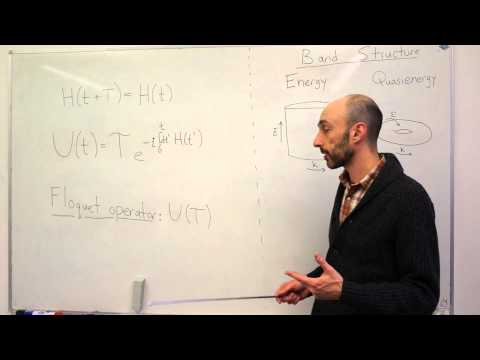

In [8]:
MoocVideo("DbyqIczcR9c", src_location="11.1-summary")

Questions about what you just learned? Ask them below!

In [9]:
MoocDiscussion("Questions", "Floquet")

MoocDiscussion(**{'display_name': 'Floquet', 'discussion_category': 'Questions', 'discussion_target': 'Floquet', 'discussion_id': '02d45aae4b1981b22b07cebd7643c6d5'})